In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import os
import h5py as hdf
plt.rcParams['figure.facecolor'] = 'white'

In [30]:
def gather_universal(path: str,filetype: str)-> list:
    subdir=path

    data=[]
    for path, subdirs, files in os.walk(subdir):
        for name in files:
            if name.endswith(filetype) and name[-5]!='t'  :

                b=(str(os.path.join(path, name)))
                data.append(b)
    return data
def sort_on_last(list:list)->list:
    df=pd.DataFrame({'list': list})
    df['nums']=df['list'].apply(lambda x:x.split('_')[-1].split('.')[0])
    df['nums']=df.nums.astype(int)
    df.sort_values(by='nums',inplace=True)
    #display(df)
    return(np.array(df['list']))
path='data/hdf/'
display(gather_universal(path,'.hdf5'))

def get_hdf_main_groups(path) -> list:
    with hdf.File(path,'r') as r:
        #display([str(i) for i in r.keys()])
        return [str(i) for i in r.keys()]

def get_hdf_group_datasets(path,groupkey) -> list:
    with hdf.File(path,'r') as r:
        #display([str(i) for i in r[groupkey].keys()])
        return [str(i) for i in r[groupkey].keys()]

def get_df_columns(path)-> pd.DataFrame:
    groups=get_hdf_main_groups(path)
    cols=[]
    for key in groups:
       cols=cols+ list(zip(list(np.full(len(get_hdf_group_datasets(path,key)),key)),
                 get_hdf_group_datasets(path,key)))

    #display(cols)
    columns=pd.MultiIndex.from_tuples(cols, names=('group', 'dataset'))
    #display(pd.DataFrame(columns=columns))
    return columns
def zero_to_nan(array):
    array[array==0.]=np.nan
    return(array)
def steps_to_df(seriespath,examplefilepath)->pd.DataFrame:
    path=seriespath
    series=pd.DataFrame(index=sort_on_last(gather_universal(path,'.hdf5')),columns=get_df_columns(examplefilepath))

    for file in series.index:
        with hdf.File(str(file),'r') as r:
            for location in series.columns:
                series.loc[file,location]=r[location[0]][location[1]][:]
    return series
series=steps_to_df('Y:\Istra Repositories\ch-gr_exports\MC_A_8yi','data/hdf/series_step_115.hdf5')

['data/hdf/series_step_104.hdf5',
 'data/hdf/series_step_105.hdf5',
 'data/hdf/series_step_106.hdf5',
 'data/hdf/series_step_113.hdf5',
 'data/hdf/series_step_114.hdf5',
 'data/hdf/series_step_115.hdf5',
 'data/hdf/series_step_122.hdf5',
 'data/hdf/series_step_123.hdf5',
 'data/hdf/series_step_124.hdf5',
 'data/hdf/series_step_131.hdf5']

In [31]:
#plt.matshow(series.loc['data/hdf/series_step_122.hdf5',('strains','strain_p1')])

In [32]:
display([i for i in series.index])
display([i for i in series.columns])

['Y:\\Istra Repositories\\ch-gr_exports\\MC_A_8yi\\series_step_0.hdf5',
 'Y:\\Istra Repositories\\ch-gr_exports\\MC_A_8yi\\series_step_1.hdf5',
 'Y:\\Istra Repositories\\ch-gr_exports\\MC_A_8yi\\series_step_2.hdf5',
 'Y:\\Istra Repositories\\ch-gr_exports\\MC_A_8yi\\series_step_3.hdf5',
 'Y:\\Istra Repositories\\ch-gr_exports\\MC_A_8yi\\series_step_4.hdf5',
 'Y:\\Istra Repositories\\ch-gr_exports\\MC_A_8yi\\series_step_5.hdf5',
 'Y:\\Istra Repositories\\ch-gr_exports\\MC_A_8yi\\series_step_6.hdf5',
 'Y:\\Istra Repositories\\ch-gr_exports\\MC_A_8yi\\series_step_7.hdf5',
 'Y:\\Istra Repositories\\ch-gr_exports\\MC_A_8yi\\series_step_8.hdf5',
 'Y:\\Istra Repositories\\ch-gr_exports\\MC_A_8yi\\series_step_9.hdf5',
 'Y:\\Istra Repositories\\ch-gr_exports\\MC_A_8yi\\series_step_10.hdf5',
 'Y:\\Istra Repositories\\ch-gr_exports\\MC_A_8yi\\series_step_11.hdf5',
 'Y:\\Istra Repositories\\ch-gr_exports\\MC_A_8yi\\series_step_12.hdf5',
 'Y:\\Istra Repositories\\ch-gr_exports\\MC_A_8yi\\series_ste

[('add_data', 'analog_channels'),
 ('coordinates', 'coordinate_x'),
 ('coordinates', 'coordinate_x_var'),
 ('coordinates', 'coordinate_y'),
 ('coordinates', 'coordinate_y_var'),
 ('coordinates', 'coordinate_z'),
 ('coordinates', 'coordinate_z_var'),
 ('coordinates', 'distance_to_plane'),
 ('coordinates', 'distance_to_sphere'),
 ('coordinates', 'mask'),
 ('coordinates', 'variance_sphere'),
 ('displacements', 'displacement_total'),
 ('displacements', 'displacement_total_rbmr'),
 ('displacements', 'displacement_total_rbmr_var'),
 ('displacements', 'displacement_total_var'),
 ('displacements', 'displacement_x'),
 ('displacements', 'displacement_x_rbmr'),
 ('displacements', 'displacement_x_var'),
 ('displacements', 'displacement_y'),
 ('displacements', 'displacement_y_rbmr'),
 ('displacements', 'displacement_y_var'),
 ('displacements', 'displacement_z'),
 ('displacements', 'displacement_z_rbmr'),
 ('displacements', 'displacement_z_var'),
 ('displacements', 'mask'),
 ('strains', 'engineering

In [33]:
#display(series.loc['data/hdf/series_step_122.hdf5',('strains','strain_p1')])

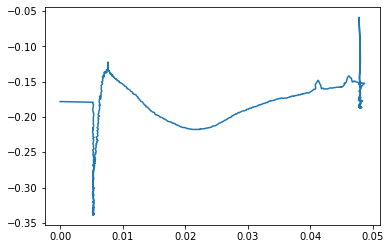

In [39]:
#plt.matshow(zero_to_nan(series.loc['data/hdf/series_step_122.hdf5',('strains','strain_p1')]))
plt.plot([np.nanmean(zero_to_nan(i)) for i in series.loc[:,('strains','strain_p1')]],[np.nanmean(zero_to_nan(i)) for i in series.loc[:,('add_data', 'analog_channels')]])
#plt.plot([np.nanmean(zero_to_nan(i)) for i in series.loc[:,('add_data', 'analog_channels')]])

In [35]:
display(series)

group                                                               add_data  \
dataset                                                      analog_channels   
Y:\Istra Repositories\ch-gr_exports\MC_A_8yi\se...  [[-0.17803990460911756]]   
Y:\Istra Repositories\ch-gr_exports\MC_A_8yi\se...  [[-0.17902631506994415]]   
Y:\Istra Repositories\ch-gr_exports\MC_A_8yi\se...  [[-0.18067033250412906]]   
Y:\Istra Repositories\ch-gr_exports\MC_A_8yi\se...  [[-0.18231434993765888]]   
Y:\Istra Repositories\ch-gr_exports\MC_A_8yi\se...   [[-0.1846159743435059]]   
...                                                                      ...   
Y:\Istra Repositories\ch-gr_exports\MC_A_8yi\se...  [[-0.15173562556412296]]   
Y:\Istra Repositories\ch-gr_exports\MC_A_8yi\se...  [[-0.15239323254240295]]   
Y:\Istra Repositories\ch-gr_exports\MC_A_8yi\se...  [[-0.15305083952057003]]   
Y:\Istra Repositories\ch-gr_exports\MC_A_8yi\se...  [[-0.15370844649862436]]   
Y:\Istra Repositories\ch-gr_exports\MC_A_8yi\se...  [[-0.15403724998760931]]   

group                                                                                     coordinates  \
dataset                                                                                  coordinate_x   
Y:\Istra Repositories\ch-gr_exports\MC_A_8yi\se...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_A_8yi\se...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_A_8yi\se...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_A_8yi\se...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_A_8yi\se...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
...                                                                                               ...   
Y:\Istra Repositories\ch-gr_exports\MC_A_8yi\se...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_A_8yi\se...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_A_8yi\se...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_A_8yi\se...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_A_8yi\se...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

group                                                                                                  \
dataset                                                                              coordinate_x_var   
Y:\Istra Repositories\ch-gr_exports\MC_A_8yi\se...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_A_8yi\se...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_A_8yi\se...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_A_8yi\se...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_A_8yi\se...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
...                                                                                               ...   
Y:\Istra Repositories\ch-gr_exports\MC_A_8yi\se...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_A_8yi\se...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_A_8yi\se...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_A_8yi\se...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_A_8yi\se...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

group                                                                                                  \
dataset                                                                                  coordinate_y   
Y:\Istra Reposito

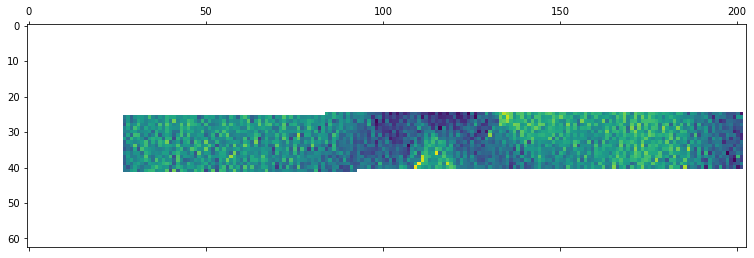

In [43]:
plt.matshow(series.iloc[520,:][('strains','strain_p1')])